In [37]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys24_daos.models import OpenPop
from recsys24_daos.datasets import to_microsoft
from recsys24_daos.model_selection import time_freq_split_current

In [38]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

## Obtain dataset

In [39]:
!pwd

/home/davo/Documents/GRASIA/recsys24-daos/notebooks


In [40]:
dfp = pd.read_csv("../data/decentraland/proposals.csv", parse_dates=['date', 'start', 'end'])
dfv = pd.read_csv("../data/decentraland/votes.csv", parse_dates=['date'])

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      1942 non-null   object        
 1   author  1942 non-null   object        
 2   date    1942 non-null   datetime64[ns]
 3   start   1942 non-null   datetime64[ns]
 4   end     1942 non-null   datetime64[ns]
dtypes: datetime64[ns](3), object(2)
memory usage: 76.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        116560 non-null  object        
 1   proposal  116560 non-null  object        
 2   voter     116560 non-null  object        
 3   date      116560 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries,

## Showing some info of the folds

In [41]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in time_freq_split_current(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2023-05-11    106129
2023-05-18    107387
2023-05-25    108802
2023-06-01    109556
2023-06-08    110250
2023-06-15    111195
2023-06-22    112105
2023-06-29    112925
2023-07-06    114417
2023-07-13    115984
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W19,18,1627,358,90.39,4.54,354,139,19.67,2.55
2023-W20,25,1346,305,53.84,4.41,811,169,32.44,4.80
2023-W21,19,1483,305,78.05,4.86,332,122,17.47,2.72
2023-W22,13,819,247,63.00,3.32,289,101,22.23,2.86
2023-W23,13,631,191,48.54,3.30,341,118,26.23,2.89
2023-W24,16,872,225,54.50,3.88,391,132,24.44,2.96
2023-W25,17,1136,278,66.82,4.09,360,148,21.18,2.43
2023-W26,10,838,278,83.80,3.01,239,107,23.90,2.23
2023-W27,21,1591,469,75.76,3.39,890,249,42.38,3.57


In [42]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W19 & 18 & 1627 & 358 & 90.39 & 4.54 & 354 & 139 & 19.67 & 2.55 \\
2023-W20 & 25 & 1346 & 305 & 53.84 & 4.41 & 811 & 169 & 32.44 & 4.80 \\
2023-W21 & 19 & 1483 & 305 & 78.05 & 4.86 & 332 & 122 & 17.47 & 2.72 \\
2023-W22 & 13 & 819 & 247 & 63.00 & 3.32 & 289 & 101 & 22.23 & 2.86 \\
2023-W23 & 13 & 631 & 191 & 48.54 & 3.30 & 341 & 118 & 26.23 & 2.89 \\
2023-W24 & 16 & 872 & 225 & 54.50 & 3.88 & 391 & 132 & 24.44 & 2.96 \\
2023-W25 & 17 & 1136 & 278 & 66.82 & 4.09 & 360 & 148 & 21.18 & 2.43 \\
2023-W26 & 10 & 838 & 278 & 83.80 & 3.01 & 239 & 107 & 23.90 & 2.23 \\
2023-W27 & 21 & 1591 & 469 & 75.76 & 3.39 & 890 & 249 & 42.38 & 3.57 \\
2023-W28

## Running openpop baseline

In [43]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [67]:
folds = list(time_freq_split_current(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):
    assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)

    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        model = OpenPop(train)
        recs = model.recommend_k_items(test['userID'].unique(), k_recs, recommend_from=open_proposals)
    
        for m, f in metrics_f.items():
            r = f(test, recs, k=k_recs)
            metrics[m+f'@{k_recs}'].append(r)
            
        
        recs = test.copy()
        recs['prediction'] = 1

        for m, f in metrics_f.items():
            # Need relevancy_method=None as they are unsorted
            r = f(test, recs, k=k_recs)
            perfectmetrics[m+f'@{k_recs}'].append(r)

  0%|          | 0/112 [00:00<?, ?it/s]

### Caching these results

In [68]:
bdf = pd.DataFrame(metrics).set_index("t")
bdf.to_csv("../data/cache/baseline.csv")
bdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.164591,0.293963,0.219932,0.376177,0.140782,0.373448,0.272424,0.598719,0.121197,0.422970,0.296964,0.756328
std,0.088598,0.161085,0.142694,0.226350,0.065290,0.167946,0.151967,0.269988,0.051757,0.158873,0.149224,0.254690
min,0.015190,0.023097,0.012220,0.027345,0.019444,0.053178,0.024507,0.071317,0.012963,0.065182,0.027671,0.101852
25%,0.107793,0.180840,0.116729,0.220419,0.098532,0.265767,0.166405,0.386284,0.086212,0.327614,0.193035,0.584866
50%,0.155114,0.272606,0.203110,0.320893,0.134848,0.359939,0.240272,0.590535,0.119941,0.420127,0.274692,0.798949
75%,0.219769,0.377936,0.306146,0.473484,0.174039,0.479992,0.369740,0.820846,0.152594,0.522750,0.383079,1.000000
max,0.497268,0.735140,0.658514,1.000000,0.339080,0.789649,0.714069,1.000000,0.307791,0.789649,0.714069,1.000000


In [69]:
pdf = pd.DataFrame(perfectmetrics).set_index("t")
pdf.to_csv("../data/cache/perfect.csv")
display(pdf.describe())
assert all( (0 <= pdf.min()) & (pdf.max() <= 1) ), "There are metrics with wrong range"

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000
mean,0.396267,1.0,0.961597,0.961597,0.228617,1.0,0.991958,0.991958,0.158637,1.0,0.998070,0.998070
std,0.097051,0.0,0.042427,0.042427,0.079498,0.0,0.011867,0.011867,0.060024,0.0,0.004052,0.004052
min,0.200000,1.0,0.713877,0.713877,0.100000,1.0,0.945214,0.945214,0.066667,1.0,0.974781,0.974781
25%,0.334530,1.0,0.950065,0.950065,0.177342,1.0,0.987986,0.987986,0.119579,1.0,0.998271,0.998271
50%,0.392204,1.0,0.970202,0.970202,0.222658,1.0,0.997621,0.997621,0.153710,1.0,1.000000,1.000000
75%,0.456445,1.0,0.991000,0.991000,0.276503,1.0,1.000000,1.000000,0.190745,1.0,1.000000,1.000000
max,0.702222,1.0,1.000000,1.000000,0.608889,1.0,1.000000,1.000000,0.446667,1.0,1.000000,1.000000


## Plotting some graphs

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.164591,0.293963,0.219932,0.376177,0.140782,0.373448,0.272424,0.598719,0.121197,0.422970,0.296964,0.756328,0.485127,0.242564
std,0.088598,0.161085,0.142694,0.226350,0.065290,0.167946,0.151967,0.269988,0.051757,0.158873,0.149224,0.254690,0.187232,0.093616
min,0.015190,0.023097,0.012220,0.027345,0.019444,0.053178,0.024507,0.071317,0.012963,0.065182,0.027671,0.101852,0.200000,0.100000
25%,0.107793,0.180840,0.116729,0.220419,0.098532,0.265767,0.166405,0.386284,0.086212,0.327614,0.193035,0.584866,0.360165,0.180082
50%,0.155114,0.272606,0.203110,0.320893,0.134848,0.359939,0.240272,0.590535,0.119941,0.420127,0.274692,0.798949,0.467795,0.233898
75%,0.219769,0.377936,0.306146,0.473484,0.174039,0.479992,0.369740,0.820846,0.152594,0.522750,0.383079,1.000000,0.574143,0.287071
max,0.497268,0.735140,0.658514,1.000000,0.339080,0.789649,0.714069,1.000000,0.307791,0.789649,0.714069,1.000000,1.353333,0.676667


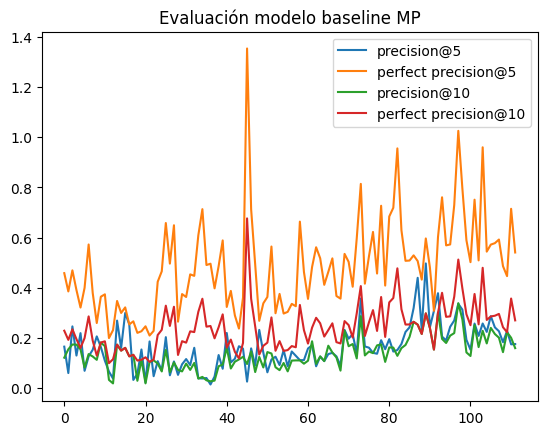

In [49]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [50]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.221133,0.317652,0.236604,0.352186,0.195841,0.415757,0.310075,0.625331,0.168421,0.477980,0.344976,0.820536,0.594497,0.297248
std,0.036484,0.053806,0.065308,0.091106,0.032717,0.077879,0.070509,0.175760,0.027148,0.069965,0.063366,0.147960,0.147132,0.073566
min,0.175100,0.217796,0.126806,0.202459,0.143919,0.317482,0.212009,0.343019,0.136036,0.375532,0.256185,0.508050,0.446729,0.223364
25%,0.189996,0.284524,0.187039,0.323228,0.167694,0.356670,0.250209,0.550864,0.149797,0.429686,0.293053,0.760931,0.517226,0.258613
50%,0.225931,0.311093,0.241310,0.356970,0.201360,0.419471,0.304259,0.592684,0.155701,0.468760,0.340216,0.797410,0.558270,0.279135
75%,0.239061,0.366925,0.290836,0.426350,0.221583,0.443381,0.366326,0.705101,0.189522,0.534261,0.405706,0.933676,0.588810,0.294405
max,0.287129,0.385956,0.329278,0.454473,0.240594,0.569957,0.417010,1.000000,0.220907,0.573062,0.429046,1.000000,0.959763,0.479882
